In [1]:
%load_ext autoreload
%autoreload 2

In [158]:
import sys
import importlib
import itertools
import matplotlib.pyplot as plt
from os import path
from keras.callbacks import TensorBoard, ModelCheckpoint
import datetime
from keras.optimizers import Adam
from keras.metrics import Precision, Recall
# Add a directory to the search path
sys.path.append('/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/Seismic_AI')
from utils.utils import (
    preprocess_traces,
    find_max_trace_length,
    read_segy_file,
    visualize_seismic_data,
    train_contrastive_ts,
    segment_into_sequences,
    create_patches,
    scale_subsequences,
    reshape_into_subsequences,
    generate_test_pairs,
    plot_aline
)
from utils.metrics import (
    pixelwise_accuracy,
    class_accuracy,
    mean_class_accuracy,
    mean_iou,
)
from utils.augmentations import (
    DataAugmentationImage,
    Compose,
    AddNoise,
    RandomCrop,
    CenterCrop,
    RandomHorizontallyFlip,
    RandomVerticallyFlip,
    FreeScale,Scale,
    RandomSizedCrop,
    RandomRotate,
    RandomSized,
    RandomHorizontallyFlip_np,
    RandomVerticallyFlip_np,
    AddNoise_np,
    RandomRotate_np,
)

from keras.models import load_model
from utils.debuggers import check_shapes, check_dataset_shapes
from scripts.predict import make_predictions_unet
from utils.visualizations import visualize_original_vs_prediction,reconstruct_from_patches, plot_original_and_reconstructed, plot_sections
from utils.patch import  SeismicProcessor, SeismicProcessor3D, SeismicProcessor1D, SeismicProcessorTests, SeismicProcessorPredict,PatchGeneratorPredict
from data.preprocess import TimeSeriesTFRecordReader,ImageMaskTFRecordWriter,TimeSeriesTFRecordWriter,TFRecordReader,TFRecordWriter
from models.contrastive_learning import ContrastiveTimeSeriesModel, TimeSeriesAugmentation, Contrastive1DCNNModel
from models.contrastive_learning import generate_pairs, contrastive_loss, augment_time_series
from models.CNNs import UNet, ResNetSegmentation, create_segmentation_vgg16_model, unet_model
import numpy as np
import tensorflow as tf
import pandas as pd
import keras as ks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
# Load training data and labels
# train_seismic = np.load(path.join(config.DATASET.ROOT, "train/train_seismic.npy"))
# train_labels = np.load(path.join(config.DATASET.ROOT, "train/train_labels.npy"))

train_labels = np.load('/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/3755060/data/train/train_labels.npy')
train_seismic = np.load('/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/3755060/data/train/train_seismic.npy')

print(f"Number of inline slices: {train_seismic.shape[0]}")
print(f"Number of crossline slices: {train_seismic.shape[1]}")
print(f"Depth dimension : {train_seismic.shape[2]}")

Number of inline slices: 401
Number of crossline slices: 701
Depth dimension : 255


In [5]:
test1_labels = np.load('/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/3755060/data/test_once/test1_labels.npy')
test1_seismic = np.load('/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/3755060/data/test_once/test1_seismic.npy')

test2_labels = np.load('/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/3755060/data/test_once/test2_labels.npy')
test2_seismic = np.load('/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/3755060/data/test_once/test2_seismic.npy')

print(f"Number of inline slices: {test2_seismic.shape[0]}")
print(f"Number of crossline slices: {test2_seismic.shape[1]}")
print(f"Depth dimension : {test2_seismic.shape[2]}")

Number of inline slices: 601
Number of crossline slices: 200
Depth dimension : 255


In [7]:
# Assuming you load your labels from a .npy file
print("Unique labels found:", np.unique(train_labels))

# Check the frequency of 255
print("Count of label 255:", np.count_nonzero(train_labels == 255))

Unique labels found: [0 1 2 3 4 5]
Count of label 255: 0


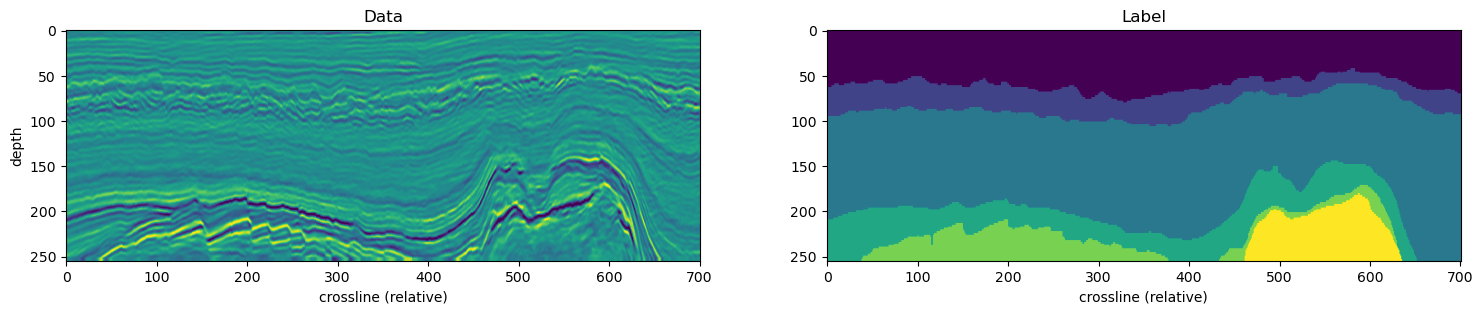

In [60]:
idx = 102
x_in = train_seismic[idx, :, :].swapaxes(0, 1)
x_inl = train_labels[idx, :, :].swapaxes(0, 1)

plot_aline(x_in, x_inl, xlabel="crossline (relative)")

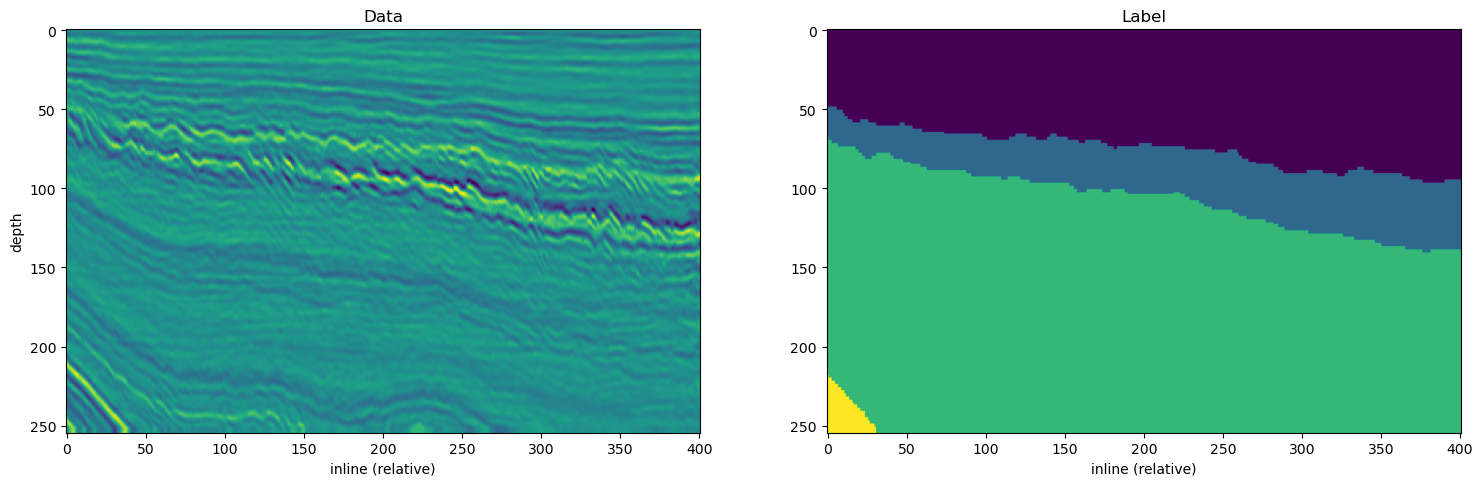

In [17]:
idx = 700
x_cr = train_seismic[:, idx, :].swapaxes(0, 1)
x_crl = train_labels[:, idx, :].swapaxes(0, 1)

plot_aline(x_cr, x_crl, xlabel="inline (relative)")


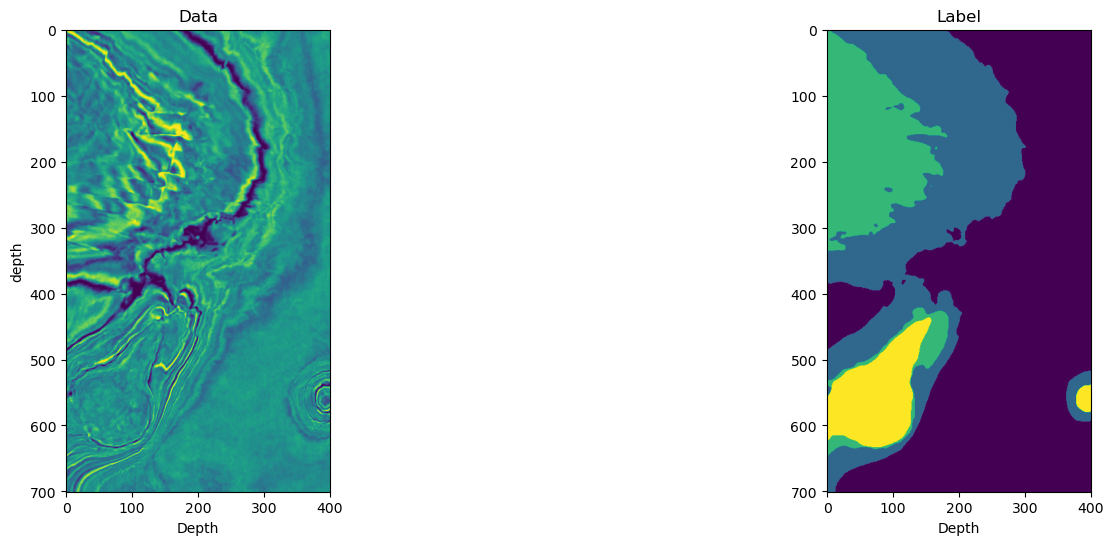

In [118]:
idx = 230
x_cr = train_seismic[:, :, idx].swapaxes(0, 1)
x_crl = train_labels[:, :, idx].swapaxes(0, 1)

plot_aline(x_cr, x_crl, xlabel="crossline")

In [21]:
# Define augmentations
augmentations = [
    RandomHorizontallyFlip_np(),
    RandomVerticallyFlip_np(),
    RandomRotate_np(30),
    AddNoise_np() 
]

# run 2Dprocessor to create tf.data.dataset input tensor & masks
processor2D = SeismicProcessor(patch_size=(128, 128), stride=(64, 64), augmentations=augmentations, num_augmentations=2, test_size=0.1)
train_dataset2, val_dataset2, train_images,train_labels = processor2D.create_datasets(train_seismic, train_labels)

In [ ]:
# 2D and 3D processor
# cube_size = (32, 32, 32)
# stride = (16, 16, 16)

# # Define augmentations
# augmentations3d = [
#     RandomHorizontallyFlip_np(),
#     RandomVerticallyFlip_np(),
#     RandomRotate_np(30),
#     AddNoise_np() 
# ]

# processor3D = SeismicProcessor3D(cube_size, stride, augmentations=augmentations, num_augmentations=2)
# train_dataset3d, val_dataset3d = processor3D.create_datasets(train_seismic, train_labels)

# num_traces = 40
# trace_length = 128  # Optional, specify if you want a specific window length

# # Define augmentations
# augmentations = [
#     AddNoise_np() 
# ]

# processor1D = SeismicProcessor(num_traces, trace_length, augmentations)
# train_dataset, val_dataset = processor1D.create_datasets(train_seismic, train_labels)

In [59]:
# check a few training examples to ensure alignment
for images, labels in train_dataset.take(1):
    #predictions = unet_model(images)  # Get model predictions
    #print("Predictions shape: ", predictions.shape)  # Should match output shape
    print("Labels shape: ", labels.shape)  # Should match expected label shape

Labels shape:  (128, 128, 1)


2024-05-07 17:15:12.308597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [65]:
# Define the input shape and number of classes for your specific case
input_shape = (128, 128,1)  # or (128, 128, 3) 
num_classes = 6  # lithofacies classes 

# Create the model
model_unet = unet_model(input_shape, num_classes)

# set the learning rate for the Adam optimizer
optimizer = Adam(learning_rate=0.0001)

# Compile the model
model_unet.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',  # Use sparse because class labels are encoded as a single channel. If they weren't you would use categorical_crossentroy
              metrics=['accuracy']) # pixel accuracy is only used for now

# Print the model summary to check the architecture
model_unet.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_153 (Conv2D) │ (None, 128, 128,  │        640 │ input_layer_9[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_154 (Conv2D) │ (None, 128, 128,  │     36,928 │ conv2d_153[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_32    │ (None, 64, 64,    │          0 │ conv2d_154[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_155 (Conv2D) │ (None, 64, 64,    │     73,856 │ max_pooling2d_32… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_156 (Conv2D) │ (None, 64, 64,    │    147,584 │ conv2d_155[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_33    │ (None, 32, 32,    │          0 │ conv2d_156[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_157 (Conv2D) │ (None, 32, 32,    │    295,168 │ max_pooling2d_33… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_158 (Conv2D) │ (None, 32, 32,    │    590,080 │ conv2d_157[0][0]  │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_34    │ (None, 16, 16,    │          0 │ conv2d_158[0][0]  │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_159 (Conv2D) │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_34… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_160 (Conv2D) │ (None, 16, 16,    │  2,359,808 │ conv2d_159[0][0]  │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_35    │ (None, 8, 8, 512) │          0 │ conv2d_160[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_161 (Conv2D) │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_35… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_162 (Conv2D) │ (None, 8, 8,      │  9,438,208 │ conv2d_161[0][0]  │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_32 │ (None, 16, 16,    │  4,719,104 │ conv2d_162[0][0]  │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_32      │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 34,512,518 (131.65 MB)

 Trainable params: 34,512,518 (131.65 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
batch_size = 32  # Define the batch size that fits your model and hardware

# Shuffle the dataset for training, testing & predictions leave unshuffled since it's harder to piece back together after
dataset2 = train_dataset2.shuffle(buffer_size=20000)  # Adjust buffer size to dataset size or larger. Less leaves out some examples
val_dataset2 = val_dataset2.shuffle(buffer_size=20000)

# Batch the dataset
dataset2 = dataset2.batch(batch_size, drop_remainder=True) # Drop remainder ensures we don't have a partial batch at end that breaks the model
# prepare the validation dataset
val_dataset2 = val_dataset2.batch(batch_size, drop_remainder=True)  

# Use prefetch to improve pipeline performance, this is optional and used for training only
dataset2 = dataset2.prefetch(tf.data.experimental.AUTOTUNE)
val_dataset2 = val_dataset2.prefetch(tf.data.experimental.AUTOTUNE)


In [62]:
# Check tensor shape with batch size included
dataset = dataset2.map(check_shapes)

Image shape: (32, 128, 128, 1)


In [ ]:
expected_image_shape = (32, 128, 128, 1)  # Expected shape for images
expected_label_shape = (32, 128, 128, 1)  # Expected shape for labels, assuming labels are not one-hot encoded. If they were would be different

# If the dataset is large, take a subset to check, e.g., dataset.take(100) to check the first 100 batches
incorrect_shapes = check_dataset_shapes(dataset2, expected_image_shape, expected_label_shape)

In [66]:
# Set up TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True)


# Fit the model (assuming you have train_data and train_labels prepared)
history = model_unet.fit(dataset,
                    epochs=2,
                    validation_data=val_dataset,
                    callbacks=[tensorboard_callback])

Epoch 1/2
2581/2581 ━━━━━━━━━━━━━━━━━━━━ 15285s 6s/step - accuracy: 0.6386 - loss: 0.8365 - val_accuracy: 0.9489 - val_loss: 0.1378
Epoch 2/2
2581/2581 ━━━━━━━━━━━━━━━━━━━━ 14959s 6s/step - accuracy: 0.9517 - loss: 0.1297 - val_accuracy: 0.9716 - val_loss: 0.0710


In [68]:
# save model for future training or use as a tflite or keras model
model_unet.save('/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/Seismic_AI/models/Lithofacies_UNet.keras')  # Save as SavedModel format (recommended)

In [24]:
# Load the entire model for more training
loaded_model = load_model('/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/Seismic_AI/models/Lithofacies_UNet.keras')

In [25]:
# Set up TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True)


# Fit the model 
history = loaded_model.fit(dataset2,
                    epochs=1,
                    validation_data=val_dataset2,
                    callbacks=[tensorboard_callback])

2581/2581 ━━━━━━━━━━━━━━━━━━━━ 15296s 6s/step - accuracy: 0.9694 - loss: 0.0796 - val_accuracy: 0.9747 - val_loss: 0.0633


In [26]:
loaded_model.save('/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/Seismic_AI/models/Lithofacies_UNetV2.keras')  # Save as SavedModel format (recommended)

In [6]:
# Load the entire model
loaded_modelV2 = load_model('/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/Seismic_AI/models/Lithofacies_UNetV2.keras')

In [78]:
# prep test dataset for model testing.
# same as training but without validation set split and without augmentations. Also ideally don't set much overlap between images if possible 
patch_size = (128, 128)
stride = (32, 32)

processor = SeismicProcessorTests(patch_size, stride)
test_dataset1V5 = processor.create_datasets(test1_seismic,test1_labels)  
test_dataset2V2 = processor.create_datasets(test2_seismic,test2_labels)  

In [23]:
test_dataset1V4

<_TensorSliceDataset element_spec=(TensorSpec(shape=(128, 128, 1), dtype=tf.float64, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))>

In [26]:
# Batches of test data

# Define the batch size 
batch_size = 32  

# Batch the dataset
test_dataset1V4 = test_dataset1V4.batch(batch_size, drop_remainder=True)
test_dataset2V1 = test_dataset2V1.batch(batch_size, drop_remainder=True)


In [39]:
test_dataset1V4

<_BatchDataset element_spec=(TensorSpec(shape=(32, 128, 128, 1), dtype=tf.float64, name=None), TensorSpec(shape=(32, 128, 128, 1), dtype=tf.uint8, name=None))>

In [27]:
# Evaluate model on test dataset
evaluate = loaded_modelV2.evaluate(test_dataset1V4)

39/39 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.8838 - loss: 0.5107


In [ ]:
# tensorboard --logdir=logs/fit/
# tensorboard --logdir= logs/fit/20240507-172024/train/
# print("TensorBoard log directory: ", log_dir)
# run in terminal

In [40]:
# To make predictions using test dataset 2
patch_size = (128, 128)
stride = (128, 128)

processor = SeismicProcessorPredict(patch_size, stride)
predict_dataset2V2 = processor.create_datasets(test2_seismic)  


In [41]:
# Batch prediction dataset
# Define the batch size 
batch_size = 32  

predict_dataset2V2 = predict_dataset2V2.batch(batch_size, drop_remainder=True)  

In [209]:
# prediction dataset generation
patch_size = (128, 128)
stride = (32, 32)
processor = PatchGeneratorPredict(patch_size, stride)
predict_dataset2V4 = processor.create_datasets(test2_seismic)  

In [210]:
# Make predictions
predicted_lithofaciesV2 = make_predictions_unet(loaded_modelV2, predict_dataset2V4)

359/359 ━━━━━━━━━━━━━━━━━━━━ 658s 2s/step


In [211]:
# prediction dataset generation
patch_size = (128, 128)
stride = (64, 64)
processor = PatchGeneratorPredict(patch_size, stride)
predict_dataset2V5 = processor.create_datasets(test2_seismic)  

In [212]:
# Make predictions
predicted_lithofaciesV3 = make_predictions_unet(loaded_modelV2, predict_dataset2V5)

128/128 ━━━━━━━━━━━━━━━━━━━━ 232s 2s/step


In [43]:
# Make predictions
predicted_lithofaciesV1 = make_predictions_unet(loaded_modelV2, predict_dataset2V2)

31/31 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step


In [131]:
predicted_lithofaciesV1.shape

(992, 128, 128)

In [ ]:
predicted_lithofaciesV2.shape

In [59]:
test2_seismic.shape

(601, 200, 255)

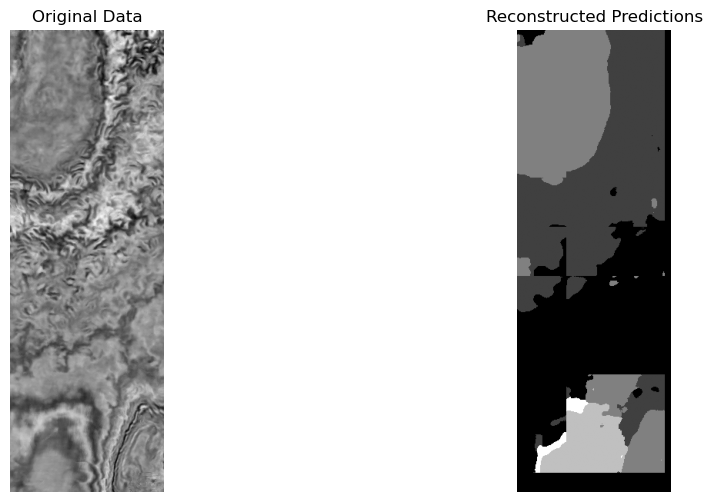

In [215]:
patch_size = (128, 128)
stride = (64, 64)  # Non-overlapping if (128,128)
original_shape = (601, 200,255)  # Example shape
depth_slice = 60 # Example depth slice to view

reconstructed_volume = reconstruct_from_patches(predicted_lithofaciesV3, original_shape, patch_size, stride)
plot_original_and_reconstructed(test2_seismic, reconstructed_volume, depth_slice)

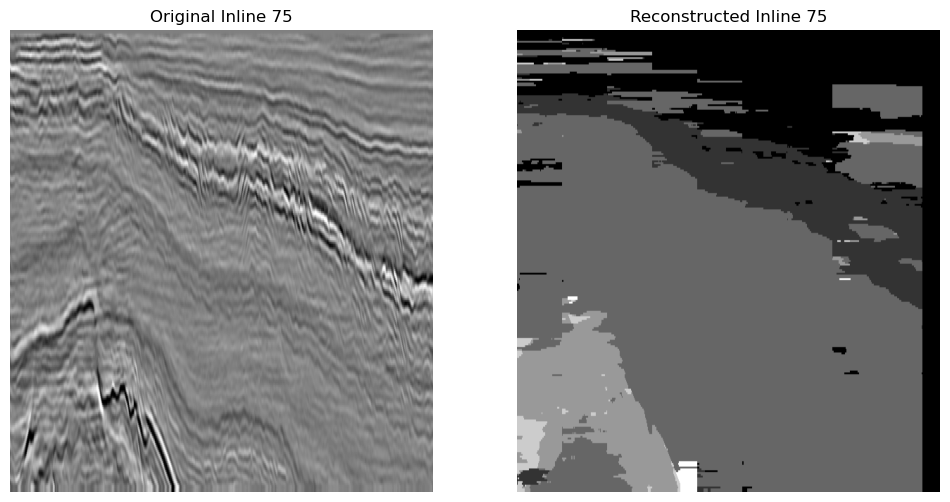

In [208]:
patch_size = (128, 128)
stride = (64, 64)  # Non-overlapping if (128,128)
original_shape = (601, 200, 255)  # shape of original dataset
inline_index = 75  # Specify an inline index to visualize
crossline_index = None  # Set to None if visualizing an inline slice

reconstructed_volume = reconstruct_from_patches(predicted_lithofaciesV3, original_shape, patch_size, stride)
plot_sections(test2_seismic, reconstructed_volume, inline=inline_index, crossline=crossline_index)

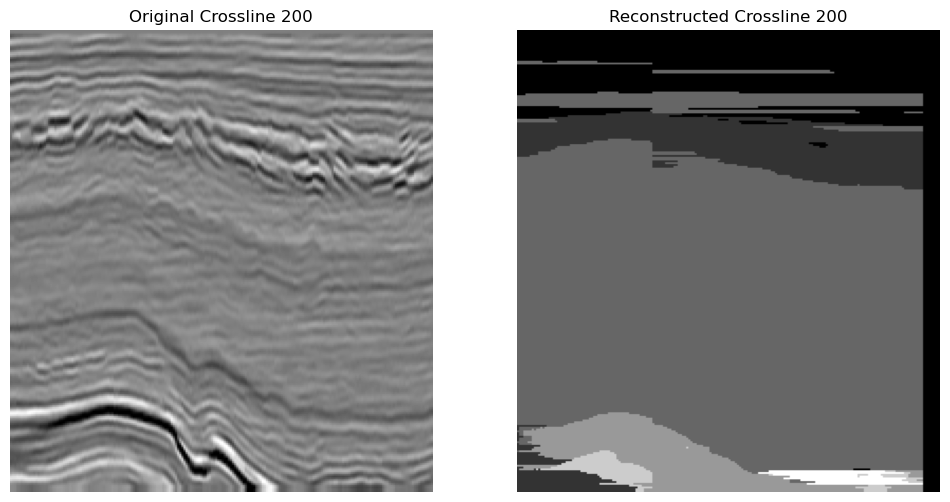

In [206]:
patch_size = (128, 128)
stride = (64, 64)  # Non-overlapping if (128,128)
original_shape = (601, 200, 255)  # shape of original dataset
inline_index = None  # Specify an inline index to visualize
crossline_index = 200  # Set to None if visualizing an inline slice

reconstructed_volume = reconstruct_from_patches(predicted_lithofaciesV3, original_shape, patch_size, stride)
plot_sections(test2_seismic, reconstructed_volume, inline=inline_index, crossline=crossline_index)

In [15]:
# plot training

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [5]:
sequence_length = 128
step_size = 128  # To create non-overlapping sequences

# Segment the dataset
sequences = segment_into_sequences(data, sequence_length, step_size)
print(f"Generated sequences shape: {sequences.shape}")
# num_sequences, sequence_length, num_features

Generated sequences shape: (4836, 128, 462)


In [6]:
sequence_length = 128  # Example choice; you'll segment your data into sequences of this length
num_features = 462  # Based on your dataset's structure
feature_dim = 64  # Example choice for the size of the embedding vector

# Initialize the model
model = ContrastiveTimeSeriesModel(input_shape=(sequence_length, num_features), feature_dim=feature_dim)


In [ ]:
num_positive_pairs = 100000  # Example quantity
num_negative_pairs = 100000  # Example quantity

model = ContrastiveTimeSeriesModel(input_shape=(128, 462), feature_dim=64)  # Example model initialization
pairs, labels = model.generate_pairs(data, num_positive_pairs, num_negative_pairs)

# Now `pairs` contains your generated positive and negative pairs,
# and `labels` contains the corresponding labels indicating whether a pair is positive or negative.

In [2]:
##################
# Training routine
##################

###############
# reading data
###############    
file_path = '/Users/vanderhoeffalex/Library/CloudStorage/OneDrive-TheBostonConsultingGroup,Inc/Desktop/F3 seismic data plus classification data for machine learning_/F3_entire.segy'
seismic_data = read_segy_file(file_path)
#visualize_seismic_data(seismic_data)

#################
# preprocess data
#################
max_length=find_max_trace_length(file_path)
data=preprocess_traces(file_path, max_length, padding_value=0)
#visualize_seismic_data(data)

####################
# subsequence length
####################
sequence_length = 128
step_size = 128  # To create non-overlapping sequences

# Reshape the data into subsequences
subsequences = reshape_into_subsequences(data, sequence_length, step_size)
#sequences = segment_into_sequences(data, sequence_length, step_size)
print(f"Generated sequences shape: {subsequences.shape}")

################
# create patches
################
# Create patches from data
# patch_size = 500  # Length of each patch
# step = 500  # Step size between patches
# patches = create_patches(data, patch_size, step)

# Scale the subsequences
#subsequences_scaled, scaler = scale_subsequences(sequences)

#############
# Split data
#############

# Lets change this. We want to train on the whole dataset, then test on the whole dataset without augmented pairs.
# after we do this, 
X_train_val, X_test = train_test_split(subsequences, test_size=0.15, random_state=42)
X_train, X_val = train_test_split(X_train_val, test_size=0.15, random_state=42)  

#############
# Scale data
#############
# scaler = StandardScaler()
# # X_train_scaled = scaler.fit_transform(X_train)
# # X_val_scaled = scaler.transform(X_val)
# # X_test_scaled = scaler.transform(X_test)
# train_patches = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
# val_patches = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
# test_patches = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

#############################
# Generate pairs for training
#############################
# Assuming your model and generate_pairs function are defined
pairs_train, labels_train = generate_pairs(X_train, num_pairs=100000, positive_ratio=0.5)
pairs_val, labels_val = generate_pairs(X_val, num_pairs=20000, positive_ratio=0.5)
pairs_test, labels_test = generate_test_pairs(X_test, num_pairs=10000)

Generated sequences shape: (4836, 128, 462)


In [3]:
pairs_train.shape

(100000, 2, 128, 462)

In [4]:
#############
# Train model 
#############
#(assuming model is instance of ContrastiveTimeSeriesModel or similar)
#model.train_model(tf.data.Dataset.from_tensor_slices((pairs_train, labels_train)), epochs=50)

# Assuming 'data' is your loaded and preprocessed seismic dataset
#pairs, labels = generate_pairs(data, num_pairs=1000, positive_ratio=0.5)


# Create dataset
train_dataset = tf.data.Dataset.from_tensor_slices((pairs_train, labels_train)).batch(32).prefetch(tf.data.AUTOTUNE)

# Initialize and train the model
input_shape = (128, 462)  # Example input shape
feature_dim = 64  # Embedding size
model = Contrastive1DCNNModel(input_shape=input_shape, feature_dim=feature_dim)

model.summary()  # To see the detailed architecture of the model



: 

In [24]:
#############
# Train model 
#############

model.train_model(train_dataset, epochs=10)

Epoch 1/10


313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.0000e+00
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0000e+00
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0000e+00
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0000e+00
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0000e+00
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.0000e+00
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0000e+00
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0000e+00
Epoch 9/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0000e+00
Epoch 10/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.0000e+00


In [6]:
embeddings = model.get_embeddings(model, train_dataset)

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


In [21]:
embeddings_array = np.array(embeddings) 
#embeddings[1].shape
embeddings_array.shape

(2, 10000, 64)

In [27]:
#############
# Train model 
#############


# First Embedding (output_1): Represents the embedding of the first element of the input pair.
# Second Embedding (output_2): Represents the embedding of the second element of the input pair.

# Assuming embeddings is the array with shape (2, 10000, 64)
embeddings_1 = embeddings_array[0]  # First set of embeddings
embeddings_2 = embeddings_array[1]  # Second set of embeddings


# Cluster the embeddings using K-means
cluster_labels_kmeans_1 = model.cluster_embeddings(embeddings_1, method='kmeans', n_clusters=5)
cluster_labels_kmeans_2 = model.cluster_embeddings(embeddings_2, method='kmeans', n_clusters=5)


# Concatenate embeddings along the feature axis for joint clustering
combined_embeddings = np.concatenate((embeddings_1, embeddings_2), axis=1)  # shape becomes (10000, 128)
kmeans_combined = model.cluster_embeddings(combined_embeddings, method='kmeans', n_clusters=5)
# Or cluster the embeddings using hierarchical clustering
#cluster_labels_hierarchical = model.cluster_embeddings(embeddings, method='hierarchical', n_clusters=5, linkage_method='ward')

# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# tsne = TSNE(n_components=2, random_state=42)
# test_embeddings_2d = tsne.fit_transform(cluster_labels_kmeans_1)

# plt.figure(figsize=(8, 6))
# plt.scatter(test_embeddings_2d[:, 0], test_embeddings_2d[:, 1], alpha=0.5)
# plt.title('t-SNE plot of Test Embeddings')
# plt.xlabel('t-SNE Dimension 1')
# plt.ylabel('t-SNE Dimension 2')
# plt.show()

# Visualize using t-SNE
#model.visualize_clusters(embeddings, cluster_labels_kmeans, method='tsne')

# Visualize using UMAP
#model.visualize_clusters(embeddings, cluster_labels_hierarchical, method='umap')

In [29]:
cluster_labels_kmeans_1

# Assuming 'cluster_labels' is a flat array where each label corresponds to a segment of a trace
# and you know the 'time_steps' used to segment each trace.
time_steps = 619101  # total number of time steps you mentioned initially
traces = 462  # total number of traces

# Example reshaping if you clustered on individual segments or full traces directly
cluster_labels_reshaped = cluster_labels_kmeans_1.reshape((time_steps, traces))

ValueError: cannot reshape array of size 10000 into shape (619101,462)

In [9]:
test_dataset = tf.data.Dataset.from_tensor_slices(X_test).batch(32)  # Adjust batch size as needed
test_embeddings = model.get_embeddings(model, test_dataset)

NameError: name 'generate_test_pairs' is not defined

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
test_embeddings_2d = tsne.fit_transform(test_embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(test_embeddings_2d[:, 0], test_embeddings_2d[:, 1], alpha=0.5)
plt.title('t-SNE plot of Test Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()